# **0. 라이브러리 불러오기**

In [1]:
import pandas as pd
import numpy as np
from lightgbm import plot_importance
from lightgbm import LGBMClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import joblib
import json
import glob

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

In [5]:
#pip install torch===1.5.0 torchvision===0.6.0 -f https://download.pytorch.org/whl/torch_stable.html
#!pip install pytorch-tabnet==3.1.1

# **1. 데이터 입력 페이지을 위한 클래스** 

In [3]:
class Data_load:
    def __init__(self, path):
        self.path = path #데이터 위치 경로 입력
    
    
    # 데이터 불러오기
    def read_data(self):
        df = pd.read_csv(self.path) 
        var_list = df.columns.tolist() #전체 변수리스트 추출
        num_var = df.select_dtypes(include='float').columns.tolist() + df.select_dtypes(include='int').columns.tolist() #수치형 변수 추출
        obj_var = [x for x in df.columns if x not in num_var] #문자형 변수 추출
        return df, var_list, num_var, obj_var

# **2. AI 모델 선택 페이지를 위한 클래스** 

In [4]:
#전처리 class
class Preprocessing:
    def __init__(self, data, var_list, num_var, obj_var, target, anomaly_per, na, outlier):
        self.df = data                                     # 데이터
        self.target = target                               # 타겟 변수
        self.var_list = var_list                           # 전체 변수 리스트
        self.num_var = num_var                             # 수치형 변수 리스트
        self.obj_var = obj_var                             # 문자형 변수 리스트
        self._anomaly_ratio = int(anomaly_per)             # 지정 이상치 범위
        self._anomaly_percentage = int(anomaly_per) / 100
        
        self.na_pre = na                                   #결측치 처리 여부
        self.outlier_pre = outlier                         #이상치 처리 여부
        
        
        if self.na_pre:
            self.df = self.na_preprocess(self.df, self._anomaly_ratio)
        
        if self.outlier_pre:
            self.df = self.outlier_preprocess(self.df, self.num_var)
        
        # 타겟 변수 num_var 일 때 분리(obj_var일 경우 라벨 인코딩해야 하기 때문에 제외하지 않음)
        if self.target in self.num_var:
            self.num_var.remove(self.target)
        
        # 표준화
        self.df = self.standardize(self.df, self.num_var)
        
        # 라벨 인코딩
        self.df = self.label_encoder(self.df, self.obj_var)
        
        if self.target in self.obj_var:
            self.obj_var.remove(self.target)
    
    # 결측치 확인 및 처리
    def na_preprocess(self, df, anomaly_per):
        
        #Column별 결측치 n% 이상 있을 경우 제외
        remove_v1 = round(df.isnull().sum() / len(df)*100, 2)
        tmp_df = df[remove_v1[remove_v1 < anomaly_per].index]
        
        #Row별 결측치 n% 이상 있을 경우 제외
        idx1 = len(tmp_df.columns) * 0.7
        return tmp_df.dropna(thresh=idx1, axis=0)
        
        
    # 이상치 제거
    def outlier_preprocess(self, df, num_var):
        num_data = df.loc[:, num_var]
        
        #IQR 기준
        quartile_1 = num_data.quantile(0.25)
        quartile_3 = num_data.quantile(0.75)
        IQR = quartile_3 - quartile_1

        condition = (num_data < (quartile_1 - 1.5 * IQR)) | (num_data > (quartile_3 + 1.5 * IQR)) # 1.5 수치가 바뀌어야함
        condition = condition.any(axis=1)
        search_df = df[condition]
        return df.drop(search_df.index, axis=0)
        
    
        
    #트리 모델이 아닐 경우 표준화 진행, 본 사업 '고객 이탈 모형'에서는 진행 x
    def standardize(self, df, num_var):
        num_data = df.loc[:, num_var]
        non_num_data = df.drop(set(num_var), axis=1)
        
        #표준화
        std_scaler = StandardScaler()
        fitted = std_scaler.fit(num_data)
        output = std_scaler.transform(num_data)
        num_data = pd.DataFrame(output, columns = num_data.columns, index=list(num_data.index.values))

        tmp_df = pd.concat([non_num_data, num_data], axis=1)
        return tmp_df
        
    
    #문자형 변수를 수치형으로 변환
    def label_encoder(self, df, obj_var):
        obj_data = df.loc[:, obj_var]
        non_obj_data = df.drop(set(obj_var), axis=1)

        #인코딩
        obj_output = pd.DataFrame()
        for obj_col in obj_var:
            lb_encoder = LabelEncoder()
            output = lb_encoder.fit_transform(obj_data.loc[:, obj_col])
            output = pd.DataFrame(output, index = list(obj_data.index.values))
            obj_output = pd.concat([obj_output, output], axis=1)
        obj_output.columns = obj_var
        tmp_df = pd.concat([obj_output, non_obj_data], axis=1)
        return tmp_df
    
    def get_df(self):
        return self.df
    

# **3. AI 모델 분석 버튼을 위한 클래스** 

In [11]:
class Modeling:
    def __init__(self, data, target, obj_var, model, OVER_SAMPLING=True, HPO=False):
        self.df = data                          #데이터
        self.target = target                    #타겟 변수 지정
        self.over_sampling = OVER_SAMPLING      #오버 샘플링 여부
        self.hpo = HPO                          #HPO 여부
        self.obj_var = obj_var
        self.model = dict()
        self.score = dict()
        self.test = dict()
        
        if model == 'tab' or model =='auto':
            self.cat_idxs, self.cat_dims = self.get_tabnet_param()
        
        self.X_train, self.X_test, self.y_train, self.y_test = self.train_test_split(self.df, self.target, self.over_sampling)
            
        
        #self.tab_fit_predict(self.cat_idxs, self.cat_dims, self.X_train, self.y_train, self.X_test, self.y_test)
        self.lgb_fit_predict(self.X_train, self.y_train, self.X_test, self.y_test, self.hpo)
        
        self.best_model_name, self.best_model, self.best_test = self.get_best_model()
        
        self.get_eval(self.best_model, self.best_test)
        self.get_plot(self.best_model, self.best_model_name, self.X_train)
            
        
    #train, valid 분리
    def train_test_split(self, df, target, over_sampling):
        df_y = pd.DataFrame(df.loc[:,target])
        df_x = df.drop(target, axis=1)
        X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.2, random_state=20)
        
        if over_sampling:
            sm = SMOTE(random_state=42)
            X_train, y_train = sm.fit_resample(X_train, y_train)
            
        return X_train, X_test, y_train, y_test
    
    
    #모델 fit
    def lgb_fit_predict(self, X_train, y_train, X_test, y_test, hpo):
        
        lgb = LGBMClassifier()
        
        if hpo :
            parameters = {'num_leaves':[20,40,60,80,100], 'min_child_samples':[5,10,15],'max_depth':[-1,5,10,20],
                      'learning_rate':[0.05,0.1,0.2],'reg_alpha':[0,0.01,0.03]}
        else: parameters = {'num_leaves':[60], 'min_child_samples':[10],'max_depth':[5],
             'learning_rate':[0.1],'reg_alpha':[0.01]}
        
        #scoring 
        cv = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
        lgb_clf = GridSearchCV(estimator = lgb, param_grid = parameters, scoring='roc_auc', cv=cv)
        
        lgb_clf.fit(X_train, np.ravel(y_train, order='C'))
        y_pred_proba = lgb_clf.predict_proba(X_test)[:,1]
        lgb_score = roc_auc_score(y_test, y_pred_proba)
        
        self.model['lgb_clf'] = lgb_clf
        self.score['lgb_clf'] = lgb_score
        self.test['lgb_clf'] = (X_test, y_test)
    
    
    def get_tabnet_param(self):
        nuinque = self.df.nunique()
        types = self.df.dtypes

        categorical_columns = []
        categorical_dims = {}
        target = self.target

        for col in self.obj_var:
            categorical_columns.append(col)
            categorical_dims[col] = self.df[col].nunique()

        features = [col for col in self.df.columns if col not in [target]]
        cat_idxs = [i for i, f in enumerate(features) if f in self.obj_var]
        cat_dims = [categorical_dims[f] for i, f in enumerate(features) if f in categorical_columns]
        
        tabnet_param = {'cat_idxs' : cat_idxs, 'cat_dims':cat_dims}
        with open('storage/tabnet_param.json', 'w') as f:
            json.dump(tabnet_param, f)
        
        return cat_idxs, cat_dims
    
    
    def tab_fit_predict(self, cat_idxs, cat_dims, X_train, y_train, X_test, y_test):
        
        X_train = X_train.values
        y_train = y_train.values.reshape(-1,)
        X_test = X_test.values
        y_test = y_test.values.reshape(-1,)
        folds=StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
        max_epochs=1
        
        for n_fold, (train_index, val_index) in enumerate(folds.split(X_train, y_train)):
    
            train_x, val_x = X_train[train_index], X_train[val_index]
            train_y, val_y = y_train[train_index], y_train[val_index]
        
            tab_clf=TabNetClassifier(cat_idxs=cat_idxs, cat_dims=cat_dims, cat_emb_dim=10, 
                     optimizer_fn = torch.optim.Adam, optimizer_params=dict(lr=1e-2),
                     scheduler_params={'step_size':50, "gamma":0.9},scheduler_fn = torch.optim.lr_scheduler.StepLR, mask_type = 'sparsemax') 
            
            tab_clf.fit(X_train=train_x, y_train=train_y,
                   eval_set=[(train_x, train_y), (val_x, val_y)], eval_name=['train', 'valid'], eval_metric=['auc'],
                    max_epochs=max_epochs, patience=20, batch_size=1024, virtual_batch_size =128, num_workers=1, weights=1, drop_last=False,)
          
            y_pred_proba = tab_clf.predict_proba(X_test)[:,1]
            tab_score = roc_auc_score(y_test, y_pred_proba)
        
            self.model[f'tab_clf_{n_fold}'] = tab_clf
            self.score[f'tab_clf_{n_fold}'] = tab_score
            self.test[f'tab_clf_{n_fold}'] = (X_test, y_test)             
        
        
    def get_best_model(self):
        
        
        best_model_name = max(self.score, key=self.score.get) 
        best_model = self.model[best_model_name]
        best_test = self.test[best_model_name]
        
        # 모델 저장
        joblib.dump(best_model, 'storage/best_model.pkl')
        
        #모델 이름 저장
        model_name = {'best_model_name' : best_model_name}
        with open('storage/model_name.json', 'w') as f:
            json.dump(model_name, f)
        
        return best_model_name, best_model, best_test
        
    
    def get_eval(self, best_model, best_test):
        
        X_test, y_test = best_test[0], best_test[1]
        pred_proba = best_model.predict_proba(X_test)[:,1]
        pred = best_model.predict(X_test)
        
        print('오차행렬 \n', confusion_matrix(y_test, pred))
        print('정확도 :', accuracy_score(y_test, pred))
        print('정밀도 : ',precision_score(y_test, pred))
        print('재현율 :', recall_score(y_test, pred))
        print('f1 score :', f1_score(y_test, pred))
        print('roc auc score :', roc_auc_score(y_test, pred_proba))
        
    def get_plot(self, best_model, best_model_name, X_train):
        
        if 'tab' in best_model_name: 
            feat_importances = best_model.feature_importances_
        else : feat_importances = best_model.best_estimator_.feature_importances_
        
        indices = np.argsort(feat_importances)
        plt.figure()
        plt.title("Feature importances")
        plt.barh(range(len(feat_importances)), feat_importances[indices], color="r", align="center")
        plt.yticks(range(len(feat_importances)), [X_train.columns[idx] for idx in indices])
        plt.ylim([-1, len(feat_importances)])
        plt.show()        
        
#mm = Modeling(df, target='churn', obj_var = obj_var, model='auto')

오차행렬 
 [[561  15]
 [ 20  71]]
정확도 : 0.9475262368815592
정밀도 :  0.8255813953488372
재현율 : 0.7802197802197802
f1 score : 0.8022598870056498
roc auc score : 0.9396558302808302


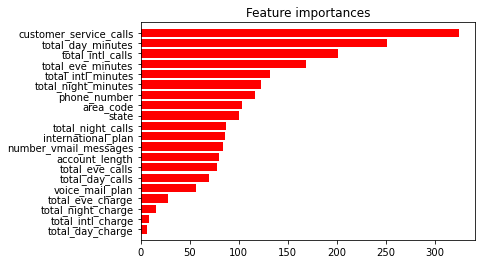

In [12]:
data, var_list, num_var, obj_var = Data_load('churn.csv').read_data()
df = Preprocessing(data, var_list, num_var, obj_var, target='churn', anomaly_per=10, na=False, outlier=False).get_df()
Modeling(df, target='churn', obj_var = obj_var, model='auto')

# **4. 새로운 데이터 예측을 위한 클래스** 

In [65]:
class Predict:
    def __init__(self, test_path, storage_path):
        self.test_path = test_path
        self.storage_path = storage_path
        
        self.test_ori_df, self.var_list, self.num_var, self.obj_var = self.read_test_data()
        
        # 표준화
        self.test_df = self.standardize(self.test_ori_df, self.num_var)
        
        # 라벨 인코딩
        self.test_df = self.label_encoder(self.test_df, self.obj_var)
        
        self.result = self.get_pred_df(self.test_df, self.storage_path, self.test_ori_df)
        
        
    # 데이터 불러오기
    def read_test_data(self):
        test_df = pd.read_csv(self.test_path) 
        var_list = test_df.columns.tolist() #전체 변수리스트 추출
        num_var = test_df.select_dtypes(include='float').columns.tolist() + test_df.select_dtypes(include='int').columns.tolist() #수치형 변수 추출
        obj_var = [x for x in test_df.columns if x not in num_var] #문자형 변수 추출
        return test_df, var_list, num_var, obj_var
   

    def standardize(self, test_df, num_var):
        num_data = test_df.loc[:, num_var]
        non_num_data = test_df.drop(set(num_var), axis=1)
        
        #표준화
        std_scaler = StandardScaler()
        fitted = std_scaler.fit(num_data)
        output = std_scaler.transform(num_data)
        num_data = pd.DataFrame(output, columns = num_data.columns, index=list(num_data.index.values))

        tmp_df = pd.concat([non_num_data, num_data], axis=1)
        return tmp_df
        
    
    #문자형 변수를 수치형으로 변환
    def label_encoder(self, test_df, obj_var):
        obj_data = test_df.loc[:, obj_var]
        non_obj_data = test_df.drop(set(obj_var), axis=1)

        #인코딩
        obj_output = pd.DataFrame()
        for obj_col in obj_var:
            lb_encoder = LabelEncoder()
            output = lb_encoder.fit_transform(obj_data.loc[:, obj_col])
            output = pd.DataFrame(output, index = list(obj_data.index.values))
            obj_output = pd.concat([obj_output, output], axis=1)
        obj_output.columns = obj_var
        tmp_df = pd.concat([obj_output, non_obj_data], axis=1)
        return tmp_df
    
    
    def get_pred_df(self, test_df, storage_path, test_ori_df):
        model_path = glob.glob(storage_path+'/*model*')[0]
        load_model=joblib.load(model_path)
        
        name_path = glob.glob(storage_path+'/*name*')[0]
        with open(name_path) as f:
            model_name = json.load(f)
            
        if 'tab' in model_name['best_model_name']:
            pred = load_model.predict(test_df.values)
            pred_proba = load_model.predict_proba(test_df.values)
            print('tab')
            
        else : 
            print('lgb')
            pred = load_model.predict(test_df)
            pred_proba = load_model.predict_proba(test_df)
            
        test_ori_df['pred'] = pred
        test_ori_df['pred_proba'] = pred_proba[:,1]
        
        return test_ori_df

In [66]:
predict = Predict('test_churn.csv', 'storage')

tab


In [67]:
predict.result

,state,account_length,area_code,phone_number,international_plan,voice_mail_plan,number_vmail_messages,total_day_minutes,total_day_calls,total_day_charge,total_eve_minutes,total_eve_calls,total_eve_charge,total_night_minutes,total_night_calls,total_night_charge,total_intl_minutes,total_intl_calls,total_intl_charge,customer_service_calls,pred,pred_proba
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,197.4,99,16.78,244.7,91,11.01,10.0,3,2.70,1,0,0.379297
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,195.5,103,16.62,254.4,103,11.45,13.7,3,3.70,1,1,0.571946
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,121.2,110,10.30,162.6,104,7.32,12.2,5,3.29,0,0,0.499145
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,61.9,88,5.26,196.9,89,8.86,6.6,7,1.78,2,0,0.465262
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,148.3,122,12.61,186.9,121,8.41,10.1,3,2.73,3,0,0.466456
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3328,AZ,192,415,414-4276,no,yes,36,156.2,77,26.55,215.5,126,18.32,279.1,83,12.56,9.9,6,2.67,2,0,0.170390
3329,WV,68,415,370-3271,no,no,0,231.1,57,39.29,153.4,55,13.04,191.3,123,8.61,9.6,4,2.59,3,1,0.723620
3330,RI,28,510,328-8230,no,no,0,180.8,109,30.74,288.8,58,24.55,191.9,91,8.64,14.1,6,3.81,2,1,0.583816
3331,CT,184,510,364-6381,yes,no,0,213.8,105,36.35,159.6,84,13.57,139.2,137,6.26,5.0,10,1.35,2,0,0.434874
